# Nepal Earthquake

From: [Kaggle Nepal Earthquake](https://www.kaggle.com/datasets/imtkaggleteam/nepal-earthquake)

### Context
The Nepal Earthquake Severity Index is designed to provide an overview of estimated severity of impacts resulting from the earthquake of 25 April 2015. It is not a replacement for first hand damage and needs assessment information, but can support prioritisation during early stages of the response. It estimates severity based on: 1) the intensity of the earthquake; 2) population; 3) vulnerability of housing and population. This index will be updated to take account of: validation against first hand reports and improvements to the severity model; improved sources of data (quality, timeliness and scale); changing requirements as the response continues. 

In [55]:
import platform
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotly
import plotly.express as px
import seaborn as sns
import sklearn
from sklearn import datasets, decomposition, metrics, preprocessing, utils
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor, plot_tree
from tqdm.notebook import tqdm

### Data

In [56]:
%config InlineBackend.figure_format="retina"  # For high DPI display

sns.set_style("darkgrid")
sns.set_context("notebook")

plotly.offline.init_notebook_mode(connected=True)

tqdm.pandas()

print(sklearn.__version__)  # Version tested on sklearn.__version__ == 1.3.x

1.3.0


### Utility Functions

In [57]:
def pprint_var(**kwargs):
    for k, v in kwargs.items():
        print(f"{k} = {v:.4g}")

#### Data loading

In [58]:
DATA = Path("data")    # Change to your data folder
assert DATA.exists()

In [59]:
eq_raw_df = pd.read_csv(DATA / "nepal-earthquake-severity-index-latest.csv", 
                        low_memory=False)

In [60]:
eq_raw_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3986 entries, 0 to 3985
Data columns (total 12 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   P_CODE               3985 non-null   object 
 1   VDC_NAME             3985 non-null   object 
 2   DISTRICT             3985 non-null   object 
 3   REGION               3985 non-null   object 
 4   Hazard (Intensity)   3985 non-null   float64
 5   Exposure             3985 non-null   float64
 6   Housing              3985 non-null   float64
 7   Poverty              3985 non-null   float64
 8   Vulnerability        3985 non-null   float64
 9   Severity             3985 non-null   float64
 10  Severity Normalized  3985 non-null   float64
 11  Severity category    3985 non-null   object 
dtypes: float64(7), object(5)
memory usage: 373.8+ KB


In [61]:
eq_raw_df.columns

Index(['P_CODE', 'VDC_NAME', 'DISTRICT', 'REGION', 'Hazard (Intensity)',
       'Exposure', 'Housing', 'Poverty', 'Vulnerability', 'Severity',
       'Severity Normalized', 'Severity category'],
      dtype='object')

In [62]:
columns = ['REGION', 'Hazard (Intensity)',
       'Exposure', 'Housing', 'Poverty', 'Vulnerability',
       'Severity category']
eq_df = eq_raw_df[columns].copy()

rename_dict = {
    "Hazard (Intensity)": "INTENSITY",
    "Severity category": "SEVERITY_CATEGORY",
    "Exposure" : "EXPOSURE",
    "Housing" : "HOUSING",
    "Poverty" : "POVERTY",
    "Vulnerability" : "VULNERABILITY"
}
# rename columns
eq_df.rename(columns=rename_dict, inplace=True)
eq_df

del eq_raw_df
eq_df

,REGION,INTENSITY,EXPOSURE,HOUSING,POVERTY,VULNERABILITY,SEVERITY_CATEGORY
0,Central,2.17,10.00,8.86,1.82,5.34,Highest
1,Central,1.72,2.26,8.40,0.82,4.61,Highest
2,Central,2.21,1.47,5.38,2.53,3.96,Highest
3,Central,2.45,0.85,8.23,0.89,4.56,Highest
4,Central,1.91,0.87,8.86,1.82,5.34,Highest
...,...,...,...,...,...,...,...
3981,Far-Western,0.00,0.00,8.77,8.26,8.52,Lowest
3982,Mid-Western,0.00,0.00,4.64,4.82,4.73,Lowest
3983,Western,0.84,0.00,5.61,3.51,4.56,Lowest
3984,Western,0.02,0.00,7.81,2.95,5.38,Lowest


In [63]:
# Drop the missing values
eq_df.dropna(axis="index", inplace=True)
eq_df.reset_index(drop=True, inplace=True)
eq_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3985 entries, 0 to 3984
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   REGION             3985 non-null   object 
 1   INTENSITY          3985 non-null   float64
 2   EXPOSURE           3985 non-null   float64
 3   HOUSING            3985 non-null   float64
 4   POVERTY            3985 non-null   float64
 5   VULNERABILITY      3985 non-null   float64
 6   SEVERITY_CATEGORY  3985 non-null   object 
dtypes: float64(5), object(2)
memory usage: 218.1+ KB


In [64]:
#sns.pairplot(eq_df.iloc[:, [1,2,3,4,5,6,7]])
#plt.show

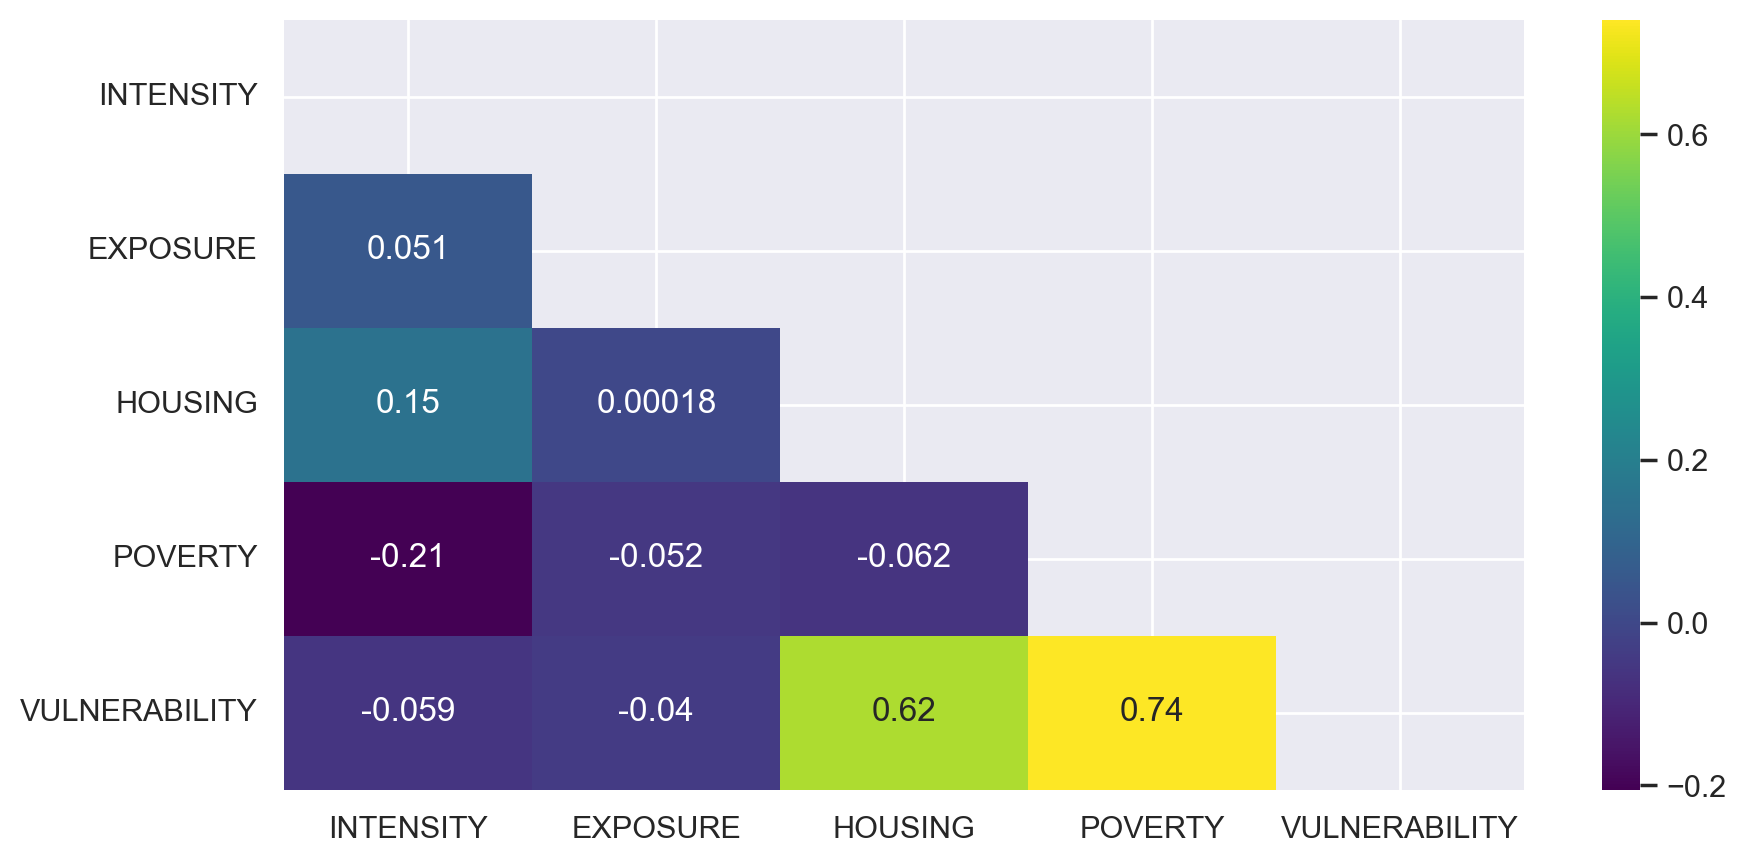

In [65]:
plt.figure(figsize=(10, 5))
mask = np.triu(np.ones_like(eq_df.corr(numeric_only=True), dtype=bool))
ax = sns.heatmap(
    eq_df.corr(numeric_only=True),
    cbar=True,
    annot=True,
    cmap="viridis",
    mask=mask,
)

In [66]:
print(eq_df.describe())
print(eq_df.describe(include='object'))

         INTENSITY     EXPOSURE      HOUSING      POVERTY  VULNERABILITY
count  3985.000000  3985.000000  3985.000000  3985.000000    3985.000000
mean      0.320537     0.067493     5.706522     5.481854       5.594635
std       0.779937     0.187551     1.953037     2.270975       1.450817
min       0.000000     0.000000     1.170000     0.000000       1.620000
25%       0.000000     0.030000     4.640000     3.330000       4.590000
50%       0.010000     0.050000     5.610000     5.620000       5.550000
75%       0.130000     0.070000     6.850000     7.350000       6.660000
max      10.000000    10.000000     9.940000    10.000000       8.830000
         REGION SEVERITY_CATEGORY
count      3985              3985
unique        5                 6
top     Central            Lowest
freq       1221              1893


In [67]:
eq_df.columns

Index(['REGION', 'INTENSITY', 'EXPOSURE', 'HOUSING', 'POVERTY',
       'VULNERABILITY', 'SEVERITY_CATEGORY'],
      dtype='object')

In [68]:
# perform one-hot encoding on categorical features
categorical_features = ['REGION']
enc = OneHotEncoder(handle_unknown='ignore')
enc.fit(eq_df[categorical_features])
df_features_encoded = pd.DataFrame(enc.transform(eq_df[categorical_features]).toarray(), columns=enc.get_feature_names_out())
# combine the one-hot encoded features with the numerical features
eq_df = pd.concat([eq_df.drop(categorical_features, axis=1), df_features_encoded ], axis=1)
eq_df

,INTENSITY,EXPOSURE,HOUSING,POVERTY,VULNERABILITY,SEVERITY_CATEGORY,REGION_Central,REGION_Eastern,REGION_Far-Western,REGION_Mid-Western,REGION_Western
0,2.17,10.00,8.86,1.82,5.34,Highest,1.0,0.0,0.0,0.0,0.0
1,1.72,2.26,8.40,0.82,4.61,Highest,1.0,0.0,0.0,0.0,0.0
2,2.21,1.47,5.38,2.53,3.96,Highest,1.0,0.0,0.0,0.0,0.0
3,2.45,0.85,8.23,0.89,4.56,Highest,1.0,0.0,0.0,0.0,0.0
4,1.91,0.87,8.86,1.82,5.34,Highest,1.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
3980,0.00,0.00,8.45,9.21,8.83,Lowest,0.0,0.0,1.0,0.0,0.0
3981,0.00,0.00,8.77,8.26,8.52,Lowest,0.0,0.0,1.0,0.0,0.0
3982,0.00,0.00,4.64,4.82,4.73,Lowest,0.0,0.0,0.0,1.0,0.0
3983,0.84,0.00,5.61,3.51,4.56,Lowest,0.0,0.0,0.0,0.0,1.0


In [69]:
eq_df.columns

Index(['INTENSITY', 'EXPOSURE', 'HOUSING', 'POVERTY', 'VULNERABILITY',
       'SEVERITY_CATEGORY', 'REGION_Central', 'REGION_Eastern',
       'REGION_Far-Western', 'REGION_Mid-Western', 'REGION_Western'],
      dtype='object')

In [71]:
severity_mapping = {
    "Lowest" : 0,
    "Low" : 1,
    "Medium-Low" : 2,
    "Medium-High" : 3,
    "High" : 4,
    "Highest" : 5
}
eq_df['SEVERITY_CATEGORY'] = eq_df['SEVERITY_CATEGORY'].map(severity_mapping)
eq_df
    

,INTENSITY,EXPOSURE,HOUSING,POVERTY,VULNERABILITY,SEVERITY_CATEGORY,REGION_Central,REGION_Eastern,REGION_Far-Western,REGION_Mid-Western,REGION_Western
0,2.17,10.00,8.86,1.82,5.34,5,1.0,0.0,0.0,0.0,0.0
1,1.72,2.26,8.40,0.82,4.61,5,1.0,0.0,0.0,0.0,0.0
2,2.21,1.47,5.38,2.53,3.96,5,1.0,0.0,0.0,0.0,0.0
3,2.45,0.85,8.23,0.89,4.56,5,1.0,0.0,0.0,0.0,0.0
4,1.91,0.87,8.86,1.82,5.34,5,1.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
3980,0.00,0.00,8.45,9.21,8.83,0,0.0,0.0,1.0,0.0,0.0
3981,0.00,0.00,8.77,8.26,8.52,0,0.0,0.0,1.0,0.0,0.0
3982,0.00,0.00,4.64,4.82,4.73,0,0.0,0.0,0.0,1.0,0.0
3983,0.84,0.00,5.61,3.51,4.56,0,0.0,0.0,0.0,0.0,1.0


In [76]:
# Split the data into train and test sets
X = eq_df.drop(columns=["SEVERITY_CATEGORY"])
y = eq_df["SEVERITY_CATEGORY"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)


In [77]:
# split the data train and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

In [78]:
X_train.shape, X_val.shape, X_test.shape

((2231, 10), (558, 10), (1196, 10))

In [80]:
model = LinearRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_val)



In [83]:
# report performance
print("Linear Regression")
print(f"R2 score: {metrics.r2_score(y_val, y_pred):.4g}")
print(f"Balanced accuracy score: {metrics.balanced_accuracy_score(y_val, y_pred.round()):.4g}")
print(f"MAE: {metrics.mean_absolute_error(y_val, y_pred):.4g}")
print(f"MSE: {metrics.mean_squared_error(y_val, y_pred):.4g}")
print(f"RMSE: {np.sqrt(metrics.mean_squared_error(y_val, y_pred)):.4g}")

print ("Classificaiton report")
print(metrics.classification_report(y_val, y_pred.round()))

Linear Regression
R2 score: 0.8214
Balanced accuracy score: 0.5551
MAE: 0.3595
MSE: 0.2736
RMSE: 0.5231
Classificaiton report
              precision    recall  f1-score   support

         0.0       0.91      0.84      0.88       262
         1.0       0.62      0.73      0.67       120
         2.0       0.72      0.88      0.79       101
         3.0       0.52      0.38      0.44        42
         4.0       0.64      0.24      0.35        29
         5.0       0.20      0.25      0.22         4
         6.0       0.00      0.00      0.00         0
        10.0       0.00      0.00      0.00         0

    accuracy                           0.76       558
   macro avg       0.45      0.42      0.42       558
weighted avg       0.77      0.76      0.75       558



/home/mazino/miniconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2394: UserWarning:

y_pred contains classes not in y_true

/home/mazino/miniconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning:

Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.

/home/mazino/miniconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning:

Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.

/home/mazino/miniconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning:

Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.



In [ ]:
"""
TODO : 
- Augment data pour équilibrer les calsses
- Polynomial feature map + PCA
- Comparer Multiclasse et Regression

"""